In [1]:
# make sure to have the last version of iicd-workshop-2024
import iicd_workshop_2024
assert iicd_workshop_2024.__version__ == "0.1.0"

In [1]:
import scvi
import torch
import torch.distributions as dist
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

adata = scvi.data.pbmc_dataset()


/Users/achille/Documents/iicd-workshop-2024/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO     Downloading file at data/gene_info_pbmc.csv                                                               
Downloading...: 909it [00:00, 13806.60it/s]              
INFO     Downloading file at data/pbmc_metadata.pickle                                                             
Downloading...: 4001it [00:00, 12627.83it/s]                            
INFO     Downloading file at data/pbmc8k/filtered_gene_bc_matrices.tar.gz                                          
Downloading...: 37559it [00:02, 14523.78it/s]                             
INFO     Extracting tar file                                                                                       
INFO     Removing extracted data at data/pbmc8k/filtered_gene_bc_matrices                                          
INFO     Downloading file at data/pbmc4k/filtered_gene_bc_matrices.tar.gz                                          
Downloading...: 100%|██████████| 18424/18424.0 [00:01<00:00, 11240.20it/s]
INFO     Extracting tar

/Users/achille/Documents/iicd-workshop-2024/.venv/lib/python3.11/site-packages/scvi/data/_built_in_data/_pbmc.py:75: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = pbmc8k.concatenate(pbmc4k)


In [2]:
from iicd_workshop_2024 import BaseGeneModel, plot_gene_distribution

In [3]:
class NormalGeneModel(BaseGeneModel):
    def __init__(self, n_genes):
        super().__init__(n_genes)
        
        # We create the mean and std parameters that will be learned
        self._mean = torch.nn.Parameter(torch.randn(n_genes)) # they are initialized randomly
        self._log_std = torch.nn.Parameter(torch.randn(n_genes)) # they are initialized randomly
        
    def get_distribution(self, gene_idx=None) -> dist.Distribution:
        mean = self._mean
        # we want to make sure std is positive
        std = torch.exp(self._log_std) + 1e-5
        
        if gene_idx is not None:
            mean = mean[gene_idx]
            std = std[gene_idx]
        
        return dist.Normal(mean, std)

In [4]:
model = NormalGeneModel(adata.n_vars)
model.fit(adata, epochs=150)

100%|██████████| 14100/14100 [00:55<00:00, 252.41it/s, loss=0.329]


In [5]:
def plot_learned_vs_empirical_mean(model, adata):
    empirical_mean = np.array(adata.X.mean(0))[0]
    learned_mean = model.get_distribution().mean    .detach().numpy()
    sns.scatterplot(x=empirical_mean, y=learned_mean)
    max_value = max(empirical_mean.max(), learned_mean.max())
    plt.plot([0, max_value], [0, max_value], color='black', linestyle='--')
    plt.xlabel("Empirical mean")
    plt.ylabel("Learned mean")
    plt.show()

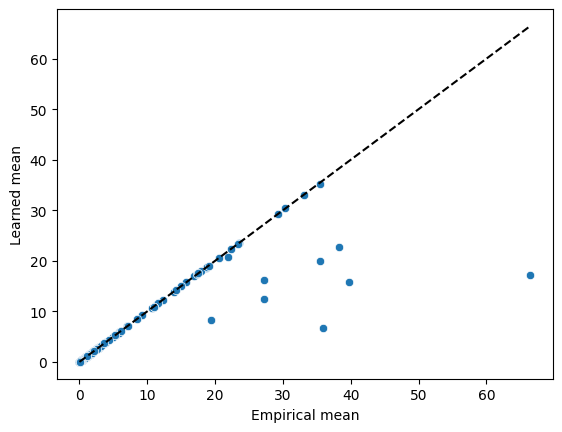

In [6]:
plot_learned_vs_empirical_mean(model, adata)


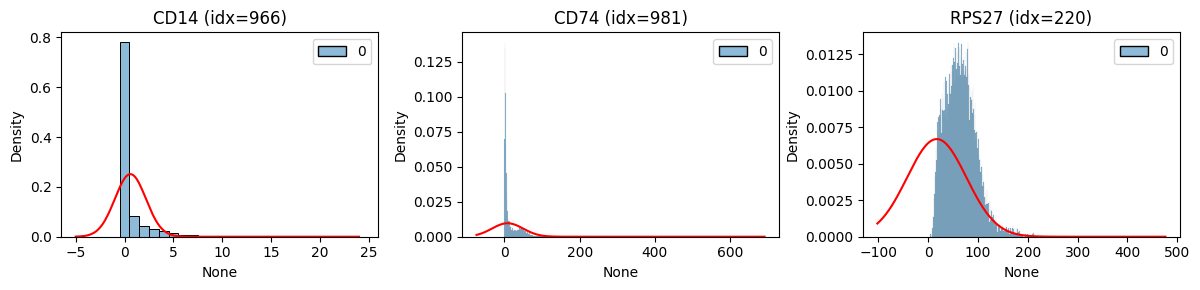

In [7]:
plot_gene_distribution(model, adata, ["CD14", "CD74", "RPS27"])


In [8]:
class PoissonGeneModel(BaseGeneModel):
    def __init__(self, n_genes):
        super().__init__(n_genes)
        
        # We create the mean parameter that will be learned (no std for Poisson)
        self._mean = torch.nn.Parameter(torch.randn(n_genes))
        
    def get_distribution(self, gene_idx=None) -> dist.Distribution:
        mean = torch.exp(self._mean)
        if gene_idx is not None:
            mean = mean[gene_idx]
            
        return dist.Poisson(mean)
    

In [9]:
model = PoissonGeneModel(adata.n_vars)
model.fit(adata, epochs=50, lr=0.02)

100%|██████████| 4700/4700 [00:15<00:00, 296.14it/s, loss=0.488]


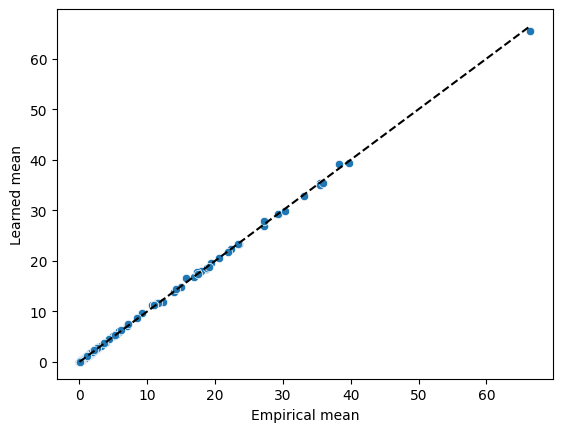

In [10]:
plot_learned_vs_empirical_mean(model, adata)

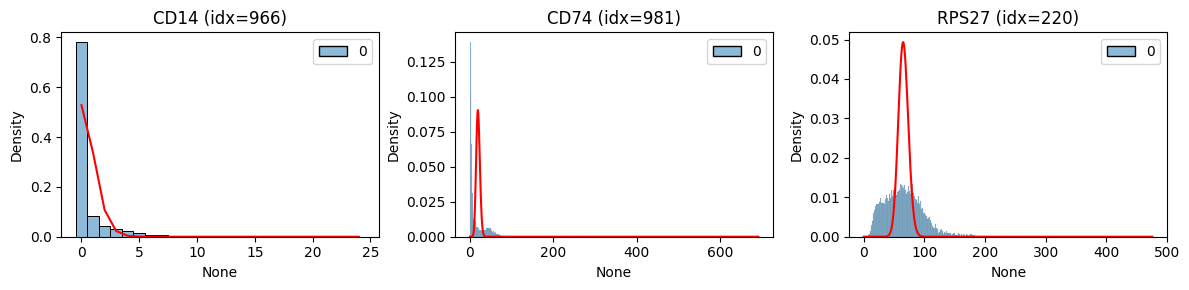

In [11]:
plot_gene_distribution(model, adata, ["CD14", "CD74", "RPS27"])


In [12]:
class NegativeBinomialGeneModel(BaseGeneModel):
    def __init__(self, n_genes):
        super().__init__(n_genes)
        
        # We create the mean and inverse dispersion parameters that will be learned
        self._mean = torch.nn.Parameter(torch.randn(n_genes))
        self._inverse_dispersion = torch.nn.Parameter(torch.randn(n_genes))

    def get_distribution(self, gene_idx=None) -> dist.Distribution:
        mean = self._mean.exp()
        inverse_dispersion = self._inverse_dispersion.exp()
        
        if gene_idx is not None:
            mean = mean[gene_idx]
            inverse_dispersion = inverse_dispersion[gene_idx]
        
        # reparameterize the negative binomial for pytorch
        total_count = inverse_dispersion
        logits = torch.log(mean + 1e-5) - torch.log(inverse_dispersion + 1e-5)
        return dist.NegativeBinomial(total_count=total_count, logits=logits)

In [13]:
model = NegativeBinomialGeneModel(adata.n_vars)
model.fit(adata, epochs=50, lr=0.02)

100%|██████████| 4700/4700 [00:32<00:00, 142.49it/s, loss=0.43] 


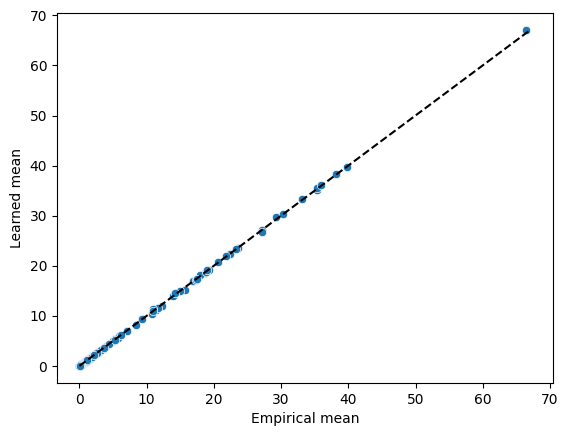

In [14]:
plot_learned_vs_empirical_mean(model, adata)


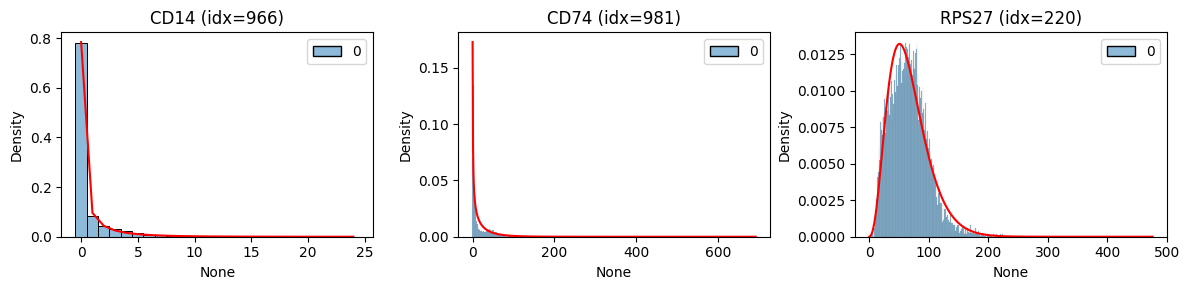

In [15]:
plot_gene_distribution(model, adata, ["CD14", "CD74", "RPS27"])


Much better fit!

In [16]:
from iicd_workshop_2024.neural_network import DenseNN
from iicd_workshop_2024.inference import fit


class LatentModel(torch.nn.Module):
    def __init__(self, n_genes: int, n_latent: int):
        super().__init__()
        self.encoder = DenseNN(n_genes, n_latent, n_hidden=128, n_layers=2)
        self.decoder = DenseNN(n_latent, n_genes, n_hidden=128, n_layers=2)
        self.theta = torch.nn.Parameter(torch.randn(n_genes))
        
    def get_distribution(self, data):
        # we encode the data into the latent space
        # we first log-transform the data for numerical stability
        latent = self.encoder(torch.log(data + 1))
        logits_mean = self.decoder(latent)        
        # we use a softmax followed by library size multiplication to ensure that
        # the gene means sum to library size
        library_size = data.sum(-1, keepdim=True)
        mean = torch.nn.functional.softmax(logits_mean, dim=-1)
        mean = mean * torch.log(library_size + 1e-5)
        
        log_dispersion = self.theta.exp()
        # we reparameterize the negative binomial for pytorch
        total_count = log_dispersion
        logits = torch.log(mean + 1e-5) - torch.log(log_dispersion + 1e-5)
        return dist.NegativeBinomial(total_count=total_count, logits=logits)
    
    def get_latent_representation(self, data):
        # wrap the data into a tensor if it is not already
        is_adata = False
        if isinstance(data, adata):
            data = torch.FloatTensor(data.X.todense())
            is_adata = True
            
        # this is the only computation of the method
        latent = self.encoder(torch.log(data + 1))
        # ##########################################
        
        if is_adata:
            return latent.detach().numpy()
        return latent
    
    def loss(self, data):
        return -self.get_distribution(data).log_prob(data).mean()

In [17]:
model = LatentModel(adata.n_vars, 10)
fit(model, adata, epochs=100)

100%|██████████| 9400/9400 [02:34<00:00, 60.80it/s, loss=0.987]


In [18]:
import scanpy as sc

latent = model.encoder(torch.log(torch.FloatTensor(adata.X.todense()) + 1)).detach().numpy()
adata.obsm["latent"] = latent
sc.pp.neighbors(adata, use_rep="latent")
sc.tl.umap(adata)
adata.var_names = adata.var["gene_symbols"]


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


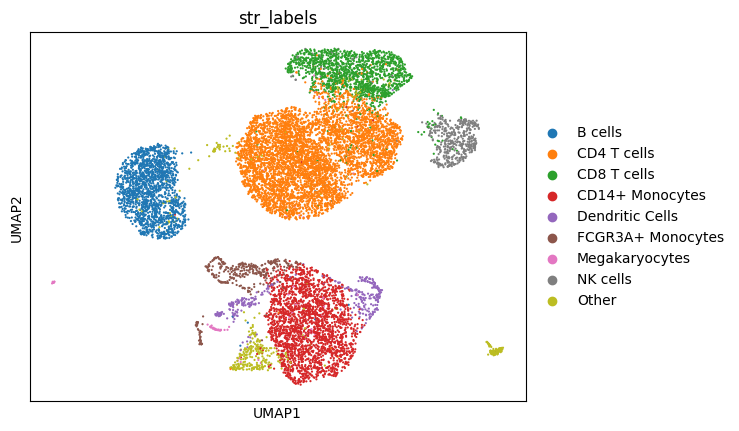

In [19]:
sc.pl.umap(adata, color=["str_labels"])


In [ ]:
!pip install scdecipher

Epoch 46 (batch 168/168) | | train elbo: 1322.29 (last epoch: 1322.64) | val ll: 1355.64:   5%|▍         | 46/1000 [44:25<15:21:24, 57.95s/it]2024-07-10 17:23:35,519 | INFO : Early stopping has been triggered.
2024-07-10 17:23:35,578 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2024-07-10 17:23:35,578 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
2024-07-10 17:23:35,580 | INFO : Saving decipher model with run_id 2024-07-10-17-23-35-sugary-charcoal-factorial.


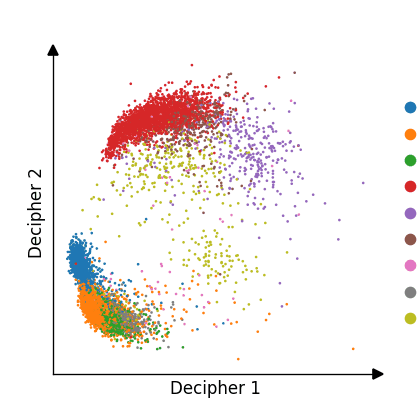

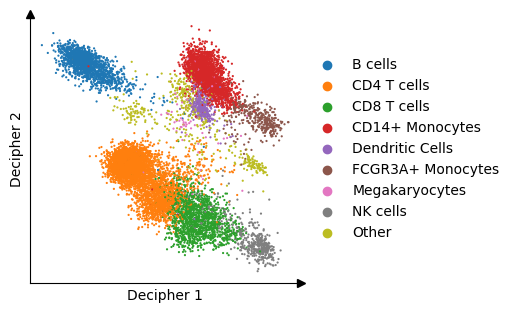

In [20]:
import decipher as dc

# color by cell type
model = dc.tl.decipher_train(adata, plot_every_k_epochs=1, plot_kwargs=dict(color='str_labels'))
